**Ship Detection challange**

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


train path = "/content/gdrive/My Drive/ship_competition/data/train/"
test path = "/content/gdrive/My Drive/ship_competition/data/val/"

After mounting drive go to "Files" on the left side. Then go to "gdrive". Find the "ship_competition" folder. Go to "data" and you will find "train" and "val". Right click on them and copy path for both. These are path for training and validation image sets.

In [ ]:
!pip install mrcnn

import numpy as np
from PIL import Image, ImageChops
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt
import os,cv2,keras
import pandas as pd
import tensorflow as tf
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from xml.etree import ElementTree
from mrcnn.utils import Dataset
from os import listdir
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from matplotlib import pyplot
from matplotlib.patches import Rectangle

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


#ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

#train_path = "/content/gdrive/My Drive/ship_competition/data/train"
#test_path = "/content/gdrive/My Drive/ship_competition/data/val"

In [ ]:
# load the dataset definitions
def load_dataset(self, dataset_dir, is_train=True):
  if file.endswith(".tiff"):
    # define one class
    self.add_class("dataset", 1, "ship")
    # define data locations
    images_dir = '/content/gdrive/My Drive/ship_competition/data/train'
    annotations_dir = '/content/gdrive/My Drive/ship_competition/data/train'
    # find all images
    for filename in listdir(images_dir):
      # extract image id
      image_id = filename[:-4]
      # skip all images after 150 if we are building the train set
      if is_train and int(image_id) >= 150:
        continue
      # skip all images before 150 if we are building the test/val set
      if not is_train and int(image_id) < 150:
        continue
      img_path = images_dir + image_id + '.tiff'
      ann_path = annotations_dir + image_id + '.xml'
      # add to dataset
      self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

In [ ]:
def extract_boxes(filename):
    tree = ElementTree.parse(filename)
    root = tree.getroot()
    boxes = list()
    boxes_final = list()
    x_train = np.zeros(5)
    y_train = np.zeros(5)
    for points in root.iter('points'):
        i = 0
        for box in points.findall('.//point'):
            x_train[i], y_train[i] = [int(x) for x in box.text.split(', ')]
            i = i + 1
        boxes += [(x_train[p], y_train[p]) for p in range(5)]
    pts = np.array([[int(x),int(y)] for(x,y) in boxes])
    #print(pts.shape)
    for j in range(int(pts.shape[0]/5)):
      for i in range(5):
        pts_ = pts[j*5:j*5+i,:]
      top_point = pts_[0]
      bottom_point = pts_[2]
      xmin = top_point[0]
      ymin = top_point[1]
      xmax = bottom_point[0]
      ymax = bottom_point[1]
      coors = [xmin, ymin, xmax, ymax]
      boxes_final.append(coors)
    width = 1000
    height = 1000
    return boxes_final, width, height

box_fi, w, h = extract_boxes(os.path.join(train_path, '1.xml'))
print(box_fi, w, h)

[[944, 986, 984, 999], [892, 957, 935, 986], [826, 921, 884, 957]] 1000 1000


xml_train = os.listdir(train_path)
x_train = np.zeros(5)
y_train = np.zeros(5)

Y_train = np.zeros((300,1000,1000)) # Sushi variable
mask_train = np.zeros((300,1000,1000)) # masked image train

k = 0

for entry in xml_train:
  if entry.endswith('.xml'):
    xml_path = os.path.join(train_path, entry)

    newStr = xml_path.split(".")[0]
    image_path = newStr + '.tiff' # loading the image corresponding to the .xml file
    im_train = Image.open(image_path)
    im_train = np.array(im_train)
    [w,h] = im_train.shape
    masked = np.zeros((1000,1000))

    tree = ET.parse(os.path.join(train_path, entry))
    root = tree.getroot()

    boxes = list()
    ctr = 0
    for points in root.iter('points'):
        i=0
        for box in points.findall('.//point'): 
          #print(box.text)
          x_train[i], y_train[i] = [int(x) for x in box.text.split(', ')]
          i = i + 1
        boxes += [(x_train[p], y_train[p]) for p in range(5)]

    pts = np.array([[int(x),int(y)] for(x,y) in boxes])
    #print(pts.shape)
    for j in range(int(pts.shape[0]/5)):
      for i in range(5):
        pts_ = pts[j*5:j*5+i,:]
      top_point = pts_[0]
      bottom_point = pts_[2]
      top_x = top_point[0]
      top_y = top_point[1]
      bottom_x = bottom_point[0]
      bottom_y = bottom_point[1]
      for u in range(top_x,bottom_x,1):
        for s in range(top_y,bottom_y,1):
          masked[u,s] = 1;
    masked_image = im_train.dot(masked)
    mask_train[k,:,:] = masked_image
    k = k + 1;
    print(k)

    #Y_train[ctr,:,:] = canvas_train
    #ctr = ctr + 1

Train: 149
Test: 151
/content/gdrive/My Drive/ship_competition/data/train/99.xml
/content/gdrive/My Drive/ship_competition/data/train/98.xml
/content/gdrive/My Drive/ship_competition/data/train/96.xml
/content/gdrive/My Drive/ship_competition/data/train/97.xml
/content/gdrive/My Drive/ship_competition/data/train/94.xml
/content/gdrive/My Drive/ship_competition/data/train/95.xml
/content/gdrive/My Drive/ship_competition/data/train/92.xml
/content/gdrive/My Drive/ship_competition/data/train/93.xml
/content/gdrive/My Drive/ship_competition/data/train/91.xml
/content/gdrive/My Drive/ship_competition/data/train/90.xml
/content/gdrive/My Drive/ship_competition/data/train/9.xml
/content/gdrive/My Drive/ship_competition/data/train/89.xml
/content/gdrive/My Drive/ship_competition/data/train/88.xml
/content/gdrive/My Drive/ship_competition/data/train/87.xml
/content/gdrive/My Drive/ship_competition/data/train/86.xml
/content/gdrive/My Drive/ship_competition/data/train/85.xml
/content/gdrive/My D

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/gdrive/My Drive/ship_competition/data/train/299.xml


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/gdrive/My Drive/ship_competition/data/train/298.xml


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/gdrive/My Drive/ship_competition/data/train/297.xml


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/gdrive/My Drive/ship_competition/data/train/296.xml


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/gdrive/My Drive/ship_competition/data/train/295.xml


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


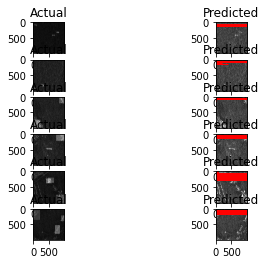

In [ ]:
# Final code
class shipDataset(Dataset):
  # load the dataset definitions
  def load_dataset(self, dataset_dir, is_train=True):
    # define one class
    self.add_class("dataset", 1, "ship")
    # define data locations
    images_dir = '/content/gdrive/My Drive/ship_competition/data/train/'
    annotations_dir = '/content/gdrive/My Drive/ship_competition/data/train/'
    # find all images
    for filename in listdir(images_dir):
      if filename.endswith(".tiff"):
        # extract image id
        image_id = filename[:-5]
        # skip all images after 150 if we are building the train set
        if is_train and int(image_id) >= 150:
          continue
        # skip all images before 150 if we are building the test/val set
        if not is_train and int(image_id) < 150:
          continue
        img_path = images_dir + image_id + '.tiff'
        ann_path = annotations_dir + image_id + '.xml'
        # add to dataset
        self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

  def extract_boxes(self, filename):
      tree = ElementTree.parse(filename)
      root = tree.getroot()
      boxes = list()
      boxes_final = list()
      x_train = np.zeros(5)
      y_train = np.zeros(5)
      for points in root.iter('points'):
          i = 0
          for box in points.findall('.//point'):
              x_train[i], y_train[i] = [int(x) for x in box.text.split(', ')]
              i = i + 1
          boxes += [(x_train[p], y_train[p]) for p in range(5)]
      pts = np.array([[int(x),int(y)] for(x,y) in boxes])
      #print(pts.shape)
      for j in range(int(pts.shape[0]/5)):
        for i in range(5):
          pts_ = pts[j*5:j*5+i,:]
        top_point = pts_[0]
        bottom_point = pts_[2]
        xmin = top_point[0]
        ymin = top_point[1]
        xmax = bottom_point[0]
        ymax = bottom_point[1]
        coors = [xmin, ymin, xmax, ymax]
        boxes_final.append(coors)
      width = 1000
      height = 1000
      return boxes_final, width, height  

  # load the masks for an image
  def load_mask(self, image_id):
    # get details of image
    info = self.image_info[image_id]
    # define box file location
    path = info['annotation']
    print(path)
    # load XML
    box_fi, w, h = self.extract_boxes(path)

    # create one array for all masks, each on a different channel
    masks = np.zeros([h, w, len(box_fi)], dtype='uint8')
    # create masks
    class_ids = list()
    for i in range(len(box_fi)):
      box = box_fi[i]
      row_s, row_e = box[1], box[3]
      col_s, col_e = box[0], box[2]
      masks[row_s:row_e, col_s:col_e, i] = 1
      class_ids.append(self.class_names.index('ship'))
    return masks, np.asarray(class_ids, dtype='int32')

  # load an image reference
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']

class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "ship_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = np.expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = np.mean(APs)
	return mAP

# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=6):
	# load image and mask
	for i in range(n_images):
		# load the image and mask
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = np.expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		# define subplot
		pyplot.subplot(n_images, 2, i*2+1)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		pyplot.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Predicted')
		ax = pyplot.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	# show the figure
	pyplot.show()

# train set
train_set = shipDataset()
train_set.load_dataset('ship', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# test/val set
test_set = shipDataset()
test_set.load_dataset('ship', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
#model.load_weights('mask_rcnn_kangaroo_cfg_0005.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)

/content/gdrive/My Drive/ship_competition/data/train/99.xml


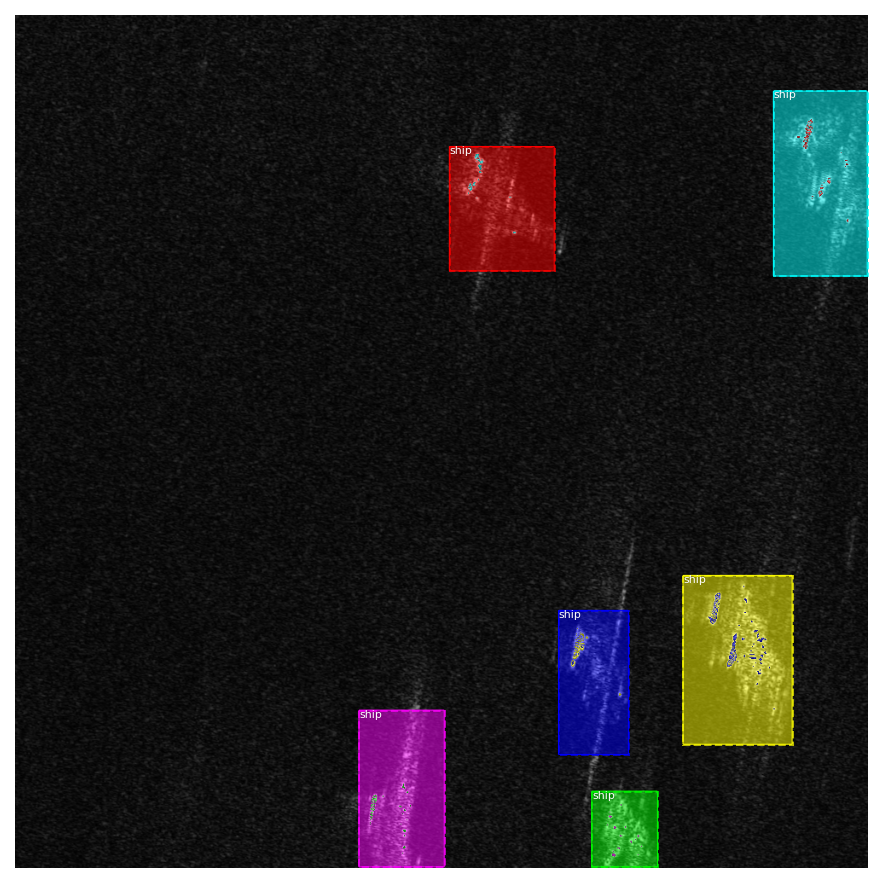

In [ ]:
# define image id
image_id = 0
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN
!git pull
!pip install mrcnn

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git
     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for mrcnn: filename=mrcnn-0.2-cp36-none-any.whl size=54931 sha256=c76c5c9cdbc8745101aace87b02d621b69d57b0ebae5523c4821e1605f071082
  Stored in directory: /root/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn


In [ ]:
!git clone https://github.com/experiencor/kangaroo.git

Cloning into 'kangaroo'...
remote: Enumerating objects: 334, done.
remote: Total 334 (delta 0), reused 0 (delta 0), pack-reused 334
Receiving objects: 100% (334/334), 18.39 MiB | 31.97 MiB/s, done.
Resolving deltas: 100% (158/158), done.


In [ ]:
import tensorflow
print(tensorflow.__version__)

2.3.0
